In [3]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt

In [4]:
spx = pd.read_csv('^GSPC.csv', index_col=0)

In [5]:
spx['daily_chg'] = spx['Adj Close'].pct_change()

Fitting GARCH model

In [6]:
model=arch.arch_model(spx['daily_chg'][1500:]*100, vol='Garch', p=1, o=1, q=1, dist='skewt')
results=model.fit()
pd.DataFrame(results.params)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 26836.9945160837
Iteration:      2,   Func. Count:     24,   Neg. LLF: 26832.12199008242
Iteration:      3,   Func. Count:     35,   Neg. LLF: 26815.127645823824
Iteration:      4,   Func. Count:     46,   Neg. LLF: 26806.145196503618
Iteration:      5,   Func. Count:     56,   Neg. LLF: 26793.497500063888
Iteration:      6,   Func. Count:     66,   Neg. LLF: 26778.540474064353
Iteration:      7,   Func. Count:     76,   Neg. LLF: 26774.319223272032
Iteration:      8,   Func. Count:     87,   Neg. LLF: 26772.3445513469
Iteration:      9,   Func. Count:     97,   Neg. LLF: 26766.883893810213
Iteration:     10,   Func. Count:    107,   Neg. LLF: 26762.98917763644
Iteration:     11,   Func. Count:    117,   Neg. LLF: 26761.72115467726
Iteration:     12,   Func. Count:    127,   Neg. LLF: 26756.082576296485
Iteration:     13,   Func. Count:    138,   Neg. LLF: 26755.805237417364
Iteration:     14,   Func. Count:    148,   Neg. LLF: 2675

,params
mu,0.037806
omega,0.009631
alpha[1],0.026977
gamma[1],0.099485
beta[1],0.914392
nu,6.171896
lambda,-0.064984


Simulating based on estimated student-t GARCH model

In [42]:
rs = np.random.RandomState([892380934, 189201902, 129129894, 9890437])
horizon = 252*60
# Save the initial state to reset later
state = rs.get_state()

dist = arch.univariate.SkewStudent(random_state=rs)
vol = arch.univariate.GARCH(p=1, o=1, q=1)
repro_mod = arch.univariate.ConstantMean(None, volatility=vol, distribution=dist)

returns=repro_mod.simulate(results.params, horizon)



Text(0.5, 1.0, 'Volatility')

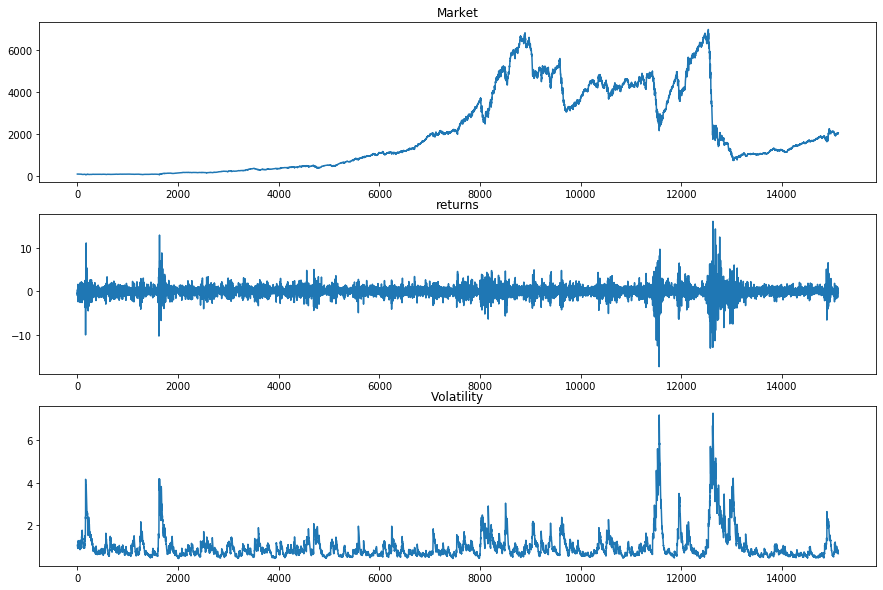

In [43]:
market = np.empty((horizon, 1))
market[0, 0] = 100

for i, err in enumerate(returns["data"].values, start=1):
    if i < (horizon):
        market[i, 0] = market[i-1, 0]*(1+err/100)

        

f, (ax1, ax2 , ax3) = plt.subplots(3, 1, figsize=(15,10))

ax1.plot(market)
ax1.set_title('Market')
#ax1.set_yscale('log')

ax2.plot(returns["data"])
ax2.set_title('returns')
#ax2.set_yscale('LOG')

ax3.plot(returns["volatility"])
ax3.set_title('Volatility')
#ax3.set_yscale('LOG')